# Partie 3: Classification de texte (exemple : détection de spam)

Dans ce notebook, nous allons :
1. Charger un jeu de données textuelles (spam vs ham).
2. Appliquer un prétraitement léger (optionnel).
3. Utiliser une **représentation vectorielle** (TF-IDF).
4. Entraîner un **modèle de classification** (Naive Bayes).
5. Évaluer les performances via des métriques (accuracy, matrice de confusion, rapport de classification).

Nous allons utiliser les bibliothèques suivantes :
- **pandas** pour la manipulation des données,
- **scikit-learn** pour la classification et l'évaluation,
- éventuellement **nltk** si nous faisons un prétraitement (tokenisation, stopwords, etc.).


In [1]:
# ========================================================================
# 1. Import des bibliothèques
# ========================================================================
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

# (Optionnel) NLTK pour un prétraitement plus poussé
#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer, WordNetLemmatizer


# 2. Chargement des données

Dans un cas réel, vous pouvez disposer d'un fichier `spam_data.csv` ou utiliser un dataset
existant (comme [SMS Spam Collection](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)).

Pour la démonstration, nous allons créer un petit dataset factice avec deux colonnes :
- `text` : le contenu du message
- `label` : "spam" ou "ham" (message légitime).


In [2]:
# ========================================================================
# 2. Création d'un petit DataFrame d'exemple
# ========================================================================
data = {
    "text": [
        "WINNER!! This is the secret code to claim your prize: 1234",
        "Hello John, how about a movie tonight?",
        "Earn $1000 per day!!! Exclusive offer, click now.",
        "Reminder: meeting tomorrow at 10am. Don't be late!",
        "Urgent!!! Your account is compromised, click here to secure now",
        "Hey buddy, long time no see. Let's catch up soon?",
        "Congratulations, you've been selected for a free gift card!",
        "Are you available for lunch tomorrow?",
    ],
    "label": [
        "spam",
        "ham",
        "spam",
        "ham",
        "spam",
        "ham",
        "spam",
        "ham"
    ]
}

df = pd.DataFrame(data)
df


,text,label
0,WINNER!! This is the secret code to claim your...,spam
1,"Hello John, how about a movie tonight?",ham
2,"Earn $1000 per day!!! Exclusive offer, click now.",spam
3,Reminder: meeting tomorrow at 10am. Don't be l...,ham
4,"Urgent!!! Your account is compromised, click h...",spam
5,"Hey buddy, long time no see. Let's catch up soon?",ham
6,"Congratulations, you've been selected for a fr...",spam
7,Are you available for lunch tomorrow?,ham


Vous devriez voir un mini-tableau avec des messages et leur label.

---
# 3. (Optionnel) Prétraitement du texte

Il est souvent utile (voir le notebook précédent) de normaliser et nettoyer les textes :  
- passer en minuscules,  
- supprimer la ponctuation, les nombres, etc.,  
- éventuellement tokeniser et supprimer les stopwords.

Ici, nous allons faire une version **simplifiée** : passage en minuscules et retrait de ponctuation de base, pour illustrer la démarche.  


In [3]:
import re
import string

def simple_preprocess(text):
    text = text.lower()
    # Retirer les caractères de ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Supprimer les chiffres (optionnel)
    text = re.sub(r"\d+", "", text)
    # Supprimer les espaces multiples
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned_text"] = df["text"].apply(simple_preprocess)
df


,text,label,cleaned_text
0,WINNER!! This is the secret code to claim your...,spam,winner this is the secret code to claim your p...
1,"Hello John, how about a movie tonight?",ham,hello john how about a movie tonight
2,"Earn $1000 per day!!! Exclusive offer, click now.",spam,earn per day exclusive offer click now
3,Reminder: meeting tomorrow at 10am. Don't be l...,ham,reminder meeting tomorrow at am dont be late
4,"Urgent!!! Your account is compromised, click h...",spam,urgent your account is compromised click here ...
5,"Hey buddy, long time no see. Let's catch up soon?",ham,hey buddy long time no see lets catch up soon
6,"Congratulations, you've been selected for a fr...",spam,congratulations youve been selected for a free...
7,Are you available for lunch tomorrow?,ham,are you available for lunch tomorrow


Vous pouvez constater dans la colonne `cleaned_text` que le texte est un peu plus standardisé.

---
# 4. Séparation en jeu d'entraînement et de test

Nous séparons notre dataset en deux parties :
- un ensemble **train** pour entraîner le modèle,
- un ensemble **test** pour évaluer sa performance sur des données "inédites".

Nous allons utiliser `train_test_split` de scikit-learn.


In [4]:
# ========================================================================
# 4. Split train/test
# ========================================================================
X = df["cleaned_text"]  # Features (text)
y = df["label"]         # Label (spam ou ham)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Taille du jeu d'entraînement :", len(X_train))
print("Taille du jeu de test        :", len(X_test))


Taille du jeu d'entraînement : 5
Taille du jeu de test        : 3


# 5. Vectorisation TF-IDF

Nous allons transformer nos textes en **matrice TF-IDF** via `TfidfVectorizer`.
- Ceci va compter la fréquence des mots tout en tenant compte de leur rareté dans l'ensemble du corpus.
- La ponctuation, les minuscules, etc. peuvent aussi être gérés directement par le vectorizer (avec les bons arguments).

Ensuite, nous entraînerons un classifieur **Naive Bayes** (`MultinomialNB`).


In [6]:
# ========================================================================
# 5. Vectorisation et entraînement du modèle
# ========================================================================

# 5.1. Création du vectorizer TF-IDF
tfidf = TfidfVectorizer()

# 5.2. Ajustement du vectorizer sur le texte d'entraînement et transformation
X_train_tfidf = tfidf.fit_transform(X_train)

# 5.3. Transformation du texte de test
X_test_tfidf = tfidf.transform(X_test)

# 5.4. Entraînement d'un classifieur Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

print("Modèle entraîné avec succès !")


Modèle entraîné avec succès !


# 6. Évaluation du modèle

Nous allons prédire les labels sur le jeu de test, puis calculer :
- l'accuracy,
- la matrice de confusion,
- le rapport de classification (précision, rappel, F1-score).

Cela permet de juger des performances globales et de voir si le modèle confond parfois spam et ham.


In [7]:
# ========================================================================
# 6. Évaluation du modèle
# ========================================================================
y_pred = model.predict(X_test_tfidf)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy :", acc)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=["spam", "ham"])
print("Matrice de confusion :\n", cm)

# Rapport de classification
report = classification_report(y_test, y_pred, labels=["spam", "ham"])
print("Rapport de classification :\n", report)


Accuracy : 0.3333333333333333
Matrice de confusion :
 [[1 0]
 [2 0]]
Rapport de classification :
               precision    recall  f1-score   support

        spam       0.33      1.00      0.50         1
         ham       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



D:\APPLICATIONS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Afin de visualiser la matrice de confusion, on peut utiliser seaborn `heatmap`.


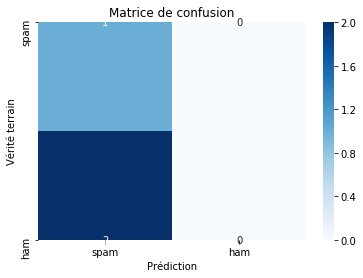

In [8]:
# Visualisation de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["spam", "ham"], yticklabels=["spam", "ham"])
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()


Pour **une classification binaire** comme « spam vs ham », la matrice de confusion est un **tableau qui compare les étiquettes réelles** (lignes) aux **étiquettes prédites** (colonnes). Dans l’exemple où on appelle :

```python
cm = confusion_matrix(y_test, y_pred, labels=["spam", "ham"])
```

- Les **lignes** correspondent aux **étiquettes réelles** : la première ligne représente les vrais *spam*, la seconde ligne représente les vrais *ham*.  
- Les **colonnes** correspondent aux **étiquettes prédites** : la première colonne est « prédit spam », la seconde colonne est « prédit ham ».

La matrice `cm` est donc de la forme :

```
        Prédit = spam    Prédit = ham
-------------------------------------
Spam |    a (TP)           b (FN)
Ham  |    c (FP)           d (TN)
```

où :

1. **a (Top-Left)** : nombre de *spams* (réels) correctement prédits comme *spam*.  
   \- On parle souvent de **True Positives** (TP) pour la classe *spam*.  

2. **b (Top-Right)** : nombre de *spams* (réels) mal classés comme *ham*.  
   \- Ce sont les **False Negatives** (FN) : le modèle a « raté » des spams.  

3. **c (Bottom-Left)** : nombre de *hams* (réels) mal classés comme *spam*.  
   \- Ce sont les **False Positives** (FP) : le modèle a donné un *faux* spam.  

4. **d (Bottom-Right)** : nombre de *hams* (réels) correctement prédits comme *ham*.  
   \- On les appelle **True Negatives** (TN) pour la classe *spam*.  

---

## Comment l’interpréter ?

- **a (TP) élevé** : le modèle détecte bien les spams.
- **b (FN) élevé** : trop de spams ne sont pas détectés (risque pour un système de sécurité).
- **c (FP) élevé** : trop de hams (messages légitimes) sont classés spam (gène pour l’utilisateur).
- **d (TN) élevé** : la plupart des messages légitimes sont reconnus comme tels.


---

## Exemple de lecture concrète

Si on obtient une matrice de confusion :

```
[[ 30   5 ]
 [  2  40 ]]
```

en supposant l’ordre (spam, ham) :

1. **30** (*row spam, col spam*) : le modèle a correctement classé 30 messages spam en spam (TP).  
2. **5**  (*row spam, col ham*) : 5 vrais spam ont été mal classés en ham (FN).  
3. **2**  (*row ham, col spam*) : 2 vrais ham ont été mal classés en spam (FP).  
4. **40** (*row ham, col ham*) : 40 vrais ham ont été correctement classés en ham (TN).

- Rappel pour spam = \( \frac{30}{30+5} = 0.857 \) (85.7% de spams détectés).  
- Précision pour spam = \( \frac{30}{30+2} = 0.938 \) (93.8% des messages étiquetés spam sont vraiment spam).  

En comparant ces valeurs, vous pouvez juger si votre modèle est acceptable selon vos objectifs (détecter un maximum de spam, minimiser les faux positifs, etc.).

---

## En résumé

La **matrice de confusion** permet de **visualiser** où se trompe votre modèle :  
- Combien de *spam* le modèle rate (FN)  
- Combien de *ham* le modèle étiquette à tort comme spam (FP)  

C’est un outil essentiel pour comprendre la **qualité** de la classification et pour orienter les **améliorations** du modèle (par exemple en ajustant les hyperparamètres, le seuil de décision, ou en augmentant la taille/l’équilibre du jeu de données).

# 7. Améliorations possibles

- **Optimisation des hyperparamètres** :  
  Par exemple, on pourrait faire une recherche de paramètres (`GridSearchCV` ou `RandomizedSearchCV`) sur les 
  paramètres du TF-IDF (ngram_range, min_df, max_df, etc.) ou sur ceux du classifieur (alpha pour le Naive Bayes).

- **Pipeline scikit-learn** :  
  Pour plus de simplicité, on peut utiliser un `Pipeline` qui enchaîne automatiquement la vectorisation et la classification.

- **Prétraitement avancé** :  
  - Utiliser la tokenisation NLTK, la suppression de stopwords, la lemmatisation, etc.  
  - Gérer les emojis, le vocabulaire spécifique à la cybersécurité, etc.

- **Approches avancées** :  
  - Autres algorithmes de classification (SVM, Logistic Regression, Random Forest).  
  - Intégration de l'apprentissage profond (transformers comme BERT).

---
# 8. Conclusion

Nous avons vu dans ce notebook :
1. Comment charger un dataset de messages (spam/ham).
2. Appliquer un prétraitement léger.
3. Transformer le texte en caractéristiques via TF-IDF.
4. Entraîner un modèle Naive Bayes.
5. Évaluer la performance sur un jeu de test (accuracy, matrice de confusion, etc.).

Ce pipeline de base constitue un point de départ pour de multiples applications de **classification de texte**, 
notamment la détection de spam, le filtrage d'e-mails malveillants, ou encore la catégorisation de tickets de support.
